# ISTEA – 2° cuatrimestre 2025
## Laboratorio de Recopilación e Integración de Datos – 2° Parcial

**Docente:** Lic. Javier Di Salvo  
**Alumnos:** Alves Mesquita, Pedro
             Della Vecchia, Agustín
             Haidbauer, Francisco
             Lattanzi, Ignacio
             Pedersen, Matías Nicolás
 
En este trabajo práctico se continúa el análisis de la base **BBDD_evaluacion.xlsx**, 
enfocándonos en la variable **`poverty`**.
El objetivo es aplicar distintas transformaciones y técnicas de análisis exploratorio de datos:

1. Seleccionar la variable: poverty.
2. Renombrar la columna “poverty” por “Pobreza”.
3. Reemplazar los 3 primeros registros de la variable renombrada según la sig. fórmula: 2*max(Pobreza).
4. Verificar la existencia de outliers, creando una nueva columna llamada Outliers” que clasifique los valores atípicos como: “Upper_bound”, “lower_bound”, “Normal.
5. Crear una nueva columna llamada “Región” que contenga 4 zonas: Norte, Cuyo, Central, Patagónica. Asignar a cada región las provincias correspondientes. Graficar.
6. Agrupar los datos de la variable renombrada en función de las 4 regiones. Graficar.
7. Crear una variable llamada “Prov-Reg” que “una” el nombre de la provincia y de la Región.
8. Crear un ratio que relacione el valor total de la variable renombrada de cada región en relación a las provincias correspondientes. Graficar.
9. Filtrar los datos, mostrando los resultados de las regiones: Central y Patagónica.
10. Pivotear los datos filtrados, mostrando el valor de las provincias como columnas.

A continuación se desarrolla cada punto, acompañado de su código en Python y la interpretación correspondiente.


## Puntos 1 y 2 – Selección de la variable `poverty`, renombrado a `Pobreza` y tratamiento de nulos

**Consigna:**  
1. Seleccionar la variable: `poverty`.  
2. Renombrar la columna `poverty` por `Pobreza`.  

Adicionalmente, retomando el TP anterior, se decide **tratar los valores nulos de `Pobreza`** 
imputándolos mediante la **mediana**, lo que permite:

- Mantener la información sin eliminar registros.  
- Reducir el impacto de posibles valores extremos.  
- Trabajar posteriormente con una variable numérica completa (sin NA).

En esta primera celda se:

- Carga el archivo `BBDD_evaluacion.xlsx` en un DataFrame llamado **`tp`**, tal como indica la consigna.  
- Se crea una copia de trabajo llamada **`df`**, para mantener el original intacto.  
- Se renombrar las columnas `poverty` → `Pobreza` y `PROVINCIA` → `Provincia`.  
- Se calculan y reemplazan los valores nulos de `Pobreza` usando la mediana.  
- Se muestra una vista preliminar de las columnas clave (`Provincia`, `Pobreza`).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Punto 1: Cargar el archivo en un DataFrame llamado "tp"
tp = pd.read_excel("BBDD_evaluacion.xlsx")

# Copia de trabajo: df (para no modificar directamente tp)
df = tp.copy()

# Renombrar columnas relevantes en df
df = df.rename(columns={
    'poverty': 'Pobreza',
    'PROVINCIA': 'Provincia'
})

# Calcular la mediana de Pobreza e imputar valores nulos
mediana_pobreza = df['Pobreza'].median()
df['Pobreza'] = df['Pobreza'].fillna(mediana_pobreza)

# Vista preliminar de las columnas clave
df[['Provincia', 'Pobreza']]


,Provincia,Pobreza
0,Buenos Aires,8.167798
1,Catamarca,9.234095
2,Córdoba,5.382380
3,Corrientes,12.747191
4,Chaco,15.862619
5,Chubut,8.051752
6,Entre Ríos,7.288751
7,Formosa,17.035583
8,Jujuy,8.956243
9,La Pampa,3.398774


## Punto 3 – Generación de valores extremos en los primeros registros

**Consigna:**  
3. Reemplazar los 3 primeros registros de la variable renombrada según la siguiente fórmula:  

\( \text{nuevo valor} = 2 \times \max(\text{Pobreza}) \).


Este paso busca **generar de forma controlada valores claramente atípicos (outliers)** en los primeros tres registros.  
La lógica es:

1. Calcular el valor máximo actual de la variable `Pobreza`.  
2. Multiplicar ese máximo por 2 para obtener un valor exagerado.  
3. Asignar ese valor a las tres primeras filas (índices 0, 1 y 2) de la columna `Pobreza`.

De esta forma, estos registros quedarán muy por encima del resto y serán detectados como outliers en el punto siguiente.


In [41]:
# Punto 3: Generar valores atípicos en los primeros 3 registros

# Calcular el valor máximo actual de Pobreza
max_pobreza = df['Pobreza'].max()  # valor más alto de la columna

# Multiplicar el máximo por 2 para obtener un valor extremo
nuevo_valor = 2 * max_pobreza

# Reemplazar los tres primeros registros (filas 0, 1 y 2) por el nuevo valor
df.loc[0:2, 'Pobreza'] = nuevo_valor

# Verificar cómo quedan los primeros registros
df[['Provincia', 'Pobreza']].head()


,Provincia,Pobreza
0,Buenos Aires,34.071166
1,Catamarca,34.071166
2,Córdoba,34.071166
3,Corrientes,12.747191
4,Chaco,15.862619


## Punto 4 – Detección de outliers mediante el criterio de IQR

**Consigna:**  
4. Verificar la existencia de outliers, creando una nueva columna llamada **`Outliers`** 
que clasifique los valores atípicos como: `"Upper_bound"`, `"lower_bound"` y `"Normal"`.

Se utiliza el método clásico basado en el **rango intercuartílico (IQR)**:

- \(Q1\): percentil 25 de `Pobreza`.  
- \(Q3\): percentil 75 de `Pobreza`.  
- \(IQR = Q3 - Q1\).  
- Límite inferior: \( Q1 - 1.5 \times IQR \).  
- Límite superior: \( Q3 + 1.5 \times IQR \).  

La nueva columna `Outliers` clasifica cada registro según:

- `"Upper_bound"` → si `Pobreza` está por encima del límite superior.  
- `"lower_bound"` → si `Pobreza` está por debajo del límite inferior.  
- `"Normal"` → si el valor está dentro de los límites.

Esto permite identificar formalmente los valores extremos, incluyendo los que fueron generados en el punto 3.


In [42]:
# Punto 4: Cálculo de IQR y clasificación de outliers

# Cálculo de cuartiles e IQR
Q1 = df['Pobreza'].quantile(0.25)
Q3 = df['Pobreza'].quantile(0.75)
IQR = Q3 - Q1

# Límites inferior y superior para detección de outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Función para clasificar cada valor de Pobreza según los límites
def clasificar_outlier(valor):
    if valor > upper_bound:
        return "Upper_bound"
    elif valor < lower_bound:
        return "lower_bound"
    else:
        return "Normal"

# Nueva columna con la clasificación de outliers
df['Outliers'] = df['Pobreza'].apply(clasificar_outlier)

df[['Provincia', 'Pobreza', 'Outliers']]


,Provincia,Pobreza,Outliers
0,Buenos Aires,34.071166,Upper_bound
1,Catamarca,34.071166,Upper_bound
2,Córdoba,34.071166,Upper_bound
3,Corrientes,12.747191,Normal
4,Chaco,15.862619,Normal
5,Chubut,8.051752,Normal
6,Entre Ríos,7.288751,Normal
7,Formosa,17.035583,Normal
8,Jujuy,8.956243,Normal
9,La Pampa,3.398774,Normal


## Punto 5 – Creación de la columna `Región` y gráfico de distribución de provincias

**Consigna:**  
5. Crear una nueva columna llamada **`Región`** que contenga 4 zonas:  
Norte, Cuyo, Central y Patagónica. Asignar a cada región las provincias correspondientes. Graficar.

Aquí se:

- Define un diccionario que asigna cada provincia a una de las 4 regiones.  
- Se crea la columna `Región` a partir de la columna `Provincia` usando `.map()`.  
- Se genera un gráfico de barras que muestra la **cantidad de provincias por región**.

Este gráfico es descriptivo y permite verificar visualmente que la asignación de provincias a regiones es consistente.


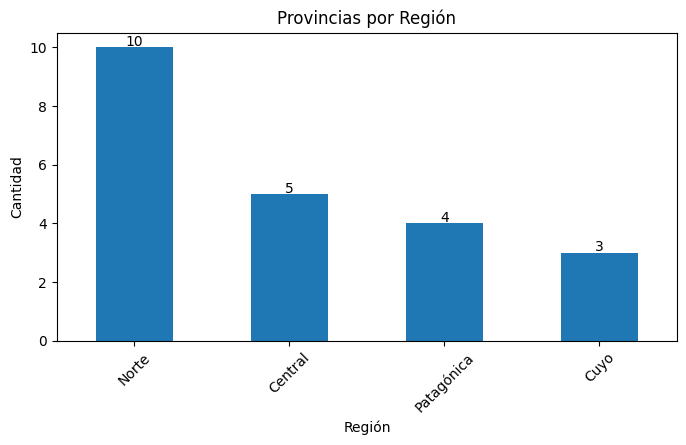

In [43]:
# Punto 5: Crear la columna Región y graficar cantidad de provincias por región

mapa_regiones = {
    'Buenos Aires': 'Central',
    'Catamarca': 'Norte',
    'Córdoba': 'Central',
    'Corrientes': 'Norte',
    'Chaco': 'Norte',
    'Chubut': 'Patagónica',
    'Entre Ríos': 'Central',
    'Formosa': 'Norte',
    'Jujuy': 'Norte',
    'La Pampa': 'Central',
    'La Rioja': 'Norte',
    'Mendoza': 'Cuyo',
    'Misiones': 'Norte',
    'Neuquén': 'Patagónica',
    'Río Negro': 'Patagónica',
    'Salta': 'Norte',
    'San Juan': 'Cuyo',
    'San Luis': 'Cuyo',
    'Santa Cruz': 'Patagónica',
    'Santa Fe': 'Central',
    'Santiago del Estero': 'Norte',
    'Tucumán': 'Norte'
}

# Aplicar el mapa de regiones a la columna Provincia
df['Región'] = df['Provincia'].map(mapa_regiones)

# Conteo de provincias por región
conteo_regiones = df['Región'].value_counts()

# Gráfico de barras con etiquetas
plt.figure(figsize=(8, 4))
barras = conteo_regiones.plot(kind='bar')

plt.title("Provincias por Región")
plt.xlabel("Región")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)

# Etiquetas numéricas sobre cada barra
for i, valor in enumerate(conteo_regiones):
    plt.text(i, valor + 0.05, str(valor), ha='center', fontsize=10)

plt.tight_layout()
plt.show()


## Punto 6 – Agrupación de la variable `Pobreza` por región y gráfico

**Consigna:**  
6. Agrupar los datos de la variable renombrada en función de las 4 regiones. Graficar.

En este punto se analiza cómo se comporta la variable `Pobreza` en cada región.  
Se calcula el **promedio de `Pobreza` por región** utilizando `groupby` y luego se grafica este resultado:

- El eje X representa las regiones (Norte, Cuyo, Central, Patagónica).  
- El eje Y muestra el valor promedio de `Pobreza` en cada una.  
- Se agregan etiquetas numéricas sobre cada barra para facilitar la lectura.

Este gráfico resume de manera clara el nivel medio de pobreza relativa de cada región.


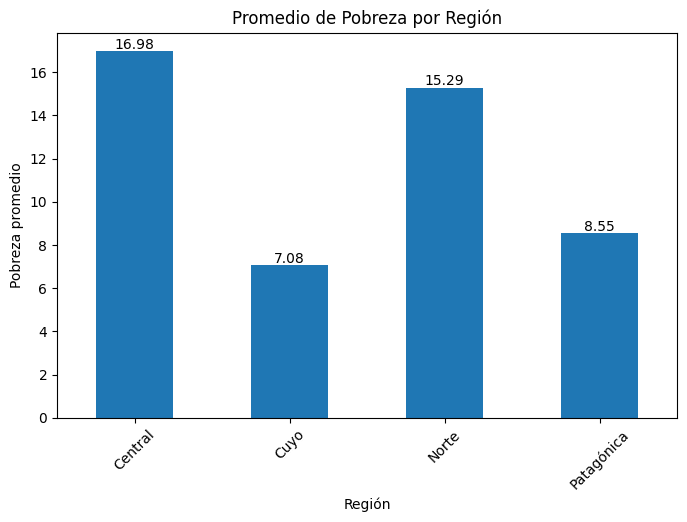

In [44]:
# Punto 6: Agrupar Pobreza por región y graficar el promedio

# Cálculo del promedio de Pobreza por región
pobreza_por_region = df.groupby('Región')['Pobreza'].mean()

# Gráfico de barras del promedio de Pobreza por región
plt.figure(figsize=(8, 5))
barras = pobreza_por_region.plot(kind='bar')

plt.title("Promedio de Pobreza por Región")
plt.xlabel("Región")
plt.ylabel("Pobreza promedio")
plt.xticks(rotation=45)

# Etiquetas numéricas sobre cada barra
for i, valor in enumerate(pobreza_por_region):
    plt.text(i, valor + 0.1, f"{valor:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


## Punto 7 – Creación de la variable combinada `Prov-Reg`

**Consigna:**  
7. Crear una variable llamada **`Prov-Reg`** que una el nombre de la provincia y de la región.

La idea es generar una etiqueta compuesta que facilite la identificación de cada observación, 
combinando ambas dimensiones geográficas:

- `Provincia`  
- `Región`  

Se construye `Prov-Reg` concatenando ambas columnas con un separador `" - "`.  
Ejemplos de valores resultantes:

- `"Buenos Aires - Central"`  
- `"Mendoza - Cuyo"`  
- `"Chubut - Patagónica"`  

Esta variable será útil en gráficos posteriores y en la interpretación del ratio del punto 8.


In [45]:
# Punto 7: Crear la variable combinada Prov-Reg

df['Prov-Reg'] = df['Provincia'] + " - " + df['Región']

df[['Provincia', 'Región', 'Prov-Reg']]


,Provincia,Región,Prov-Reg
0,Buenos Aires,Central,Buenos Aires - Central
1,Catamarca,Norte,Catamarca - Norte
2,Córdoba,Central,Córdoba - Central
3,Corrientes,Norte,Corrientes - Norte
4,Chaco,Norte,Chaco - Norte
5,Chubut,Patagónica,Chubut - Patagónica
6,Entre Ríos,Central,Entre Ríos - Central
7,Formosa,Norte,Formosa - Norte
8,Jujuy,Norte,Jujuy - Norte
9,La Pampa,Central,La Pampa - Central


## Punto 8 – Cálculo del ratio de cada provincia dentro de su región

**Consigna:**  
8. Crear un ratio que relacione el valor total de la variable renombrada de cada región 
en relación a las provincias correspondientes. Graficar.

Interpretación adoptada:  
Para cada provincia se calcula su **peso relativo dentro de la región** en términos de `Pobreza`:

\[
\text{Ratio\_Prov\_Region} = 
\frac{\text{Pobreza de la provincia}}{\text{Total de Pobreza de su región}}
\]

Pasos realizados:

1. Se calcula el total de `Pobreza` por región.  
2. Se incorpora ese total al DataFrame original.  
3. Se define la columna `Ratio_Prov_Region` como el cociente entre la pobreza de la provincia 
   y el total de pobreza de su región.  
4. Se ordenan las observaciones por región y provincia.  
5. Se genera un gráfico de barras donde cada barra representa una provincia (etiquetada como `Prov-Reg`), 
   y su altura indica el porcentaje de participación dentro de la región.

De este modo, es posible identificar qué provincias tienen mayor peso relativo en la pobreza total de cada región.


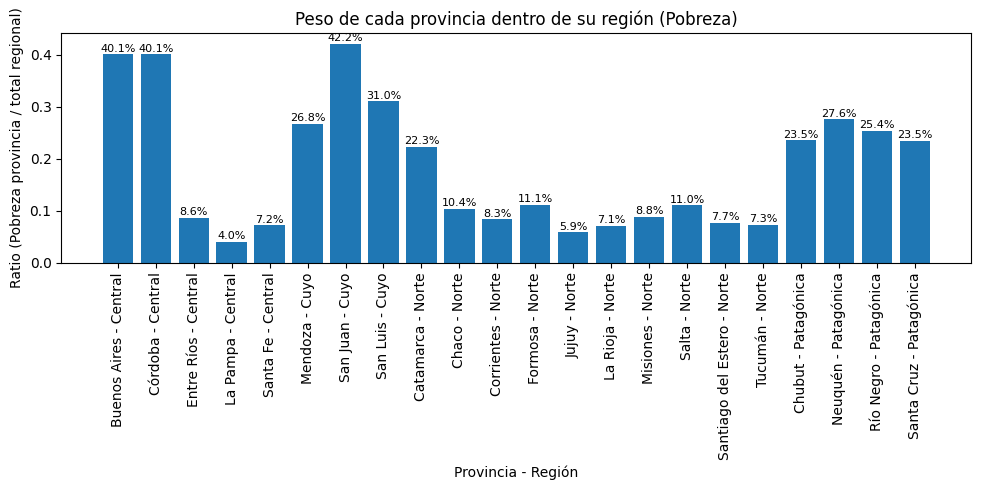

,Provincia,Región,Pobreza,total_region_pobreza,Ratio_Prov_Region
0,Buenos Aires,Central,34.071166,84.910870,0.401258
2,Córdoba,Central,34.071166,84.910870,0.401258
6,Entre Ríos,Central,7.288751,84.910870,0.085840
9,La Pampa,Central,3.398774,84.910870,0.040028
19,Santa Fe,Central,6.081012,84.910870,0.071616
11,Mendoza,Cuyo,5.692798,21.242812,0.267987
16,San Juan,Cuyo,8.956243,21.242812,0.421613
17,San Luis,Cuyo,6.593771,21.242812,0.310400
1,Catamarca,Norte,34.071166,152.921481,0.222802
4,Chaco,Norte,15.862619,152.921481,0.103730


In [46]:
# Punto 8: Ratio de cada provincia dentro de su región

# 1) Calcular el total de Pobreza por región
totales_region = df.groupby('Región')['Pobreza'].sum().rename('total_region_pobreza')

# 2) Unir ese total al DataFrame original (según la región)
df = df.merge(totales_region, left_on='Región', right_index=True)

# 3) Calcular el ratio provincia / total de la región
df['Ratio_Prov_Region'] = df['Pobreza'] / df['total_region_pobreza']

# 4) Ordenar por región y provincia para mejorar la visualización
df_ratio = df.sort_values(['Región', 'Provincia'])

# 5) Gráfico de barras del ratio por provincia (en porcentaje)
plt.figure(figsize=(10, 5))
plt.bar(df_ratio['Prov-Reg'], df_ratio['Ratio_Prov_Region'])

plt.title("Peso de cada provincia dentro de su región (Pobreza)")
plt.xlabel("Provincia - Región")
plt.ylabel("Ratio (Pobreza provincia / total regional)")
plt.xticks(rotation=90)

# Etiquetas en porcentaje sobre cada barra
for i, valor in enumerate(df_ratio['Ratio_Prov_Region']):
    plt.text(i, valor + 0.005, f"{valor * 100:.1f}%", ha='center', fontsize=8)

plt.tight_layout()
plt.show()

# Tabla resumen de apoyo
df_ratio[['Provincia', 'Región', 'Pobreza', 'total_region_pobreza', 'Ratio_Prov_Region']]


## Punto 9 – Filtro por regiones Central y Patagónica

**Consigna:**  
9. Filtrar los datos, mostrando los resultados de las regiones: Central y Patagónica.

Aquí se crea un subconjunto del DataFrame original, llamado `df_filtrado`, 
que contiene únicamente las observaciones correspondientes a las regiones:

- `Central`  
- `Patagónica`  

Este filtrado prepara la base para el punto siguiente, 
en el cual se realizará una tabla pivote utilizando solo estas dos regiones.


In [47]:
# Punto 9: Filtrar datos para las regiones Central y Patagónica

df_filtrado = df[df['Región'].isin(['Central', 'Patagónica'])]

df_filtrado[['Provincia', 'Región', 'Pobreza', 'Ratio_Prov_Region']]


,Provincia,Región,Pobreza,Ratio_Prov_Region
0,Buenos Aires,Central,34.071166,0.401258
2,Córdoba,Central,34.071166,0.401258
5,Chubut,Patagónica,8.051752,0.235352
6,Entre Ríos,Central,7.288751,0.085840
9,La Pampa,Central,3.398774,0.040028
13,Neuquén,Patagónica,9.456635,0.276417
14,Río Negro,Patagónica,8.678391,0.253669
18,Santa Cruz,Patagónica,8.024762,0.234563
19,Santa Fe,Central,6.081012,0.071616


## Punto 10 – Tabla pivote con provincias como columnas

**Consigna:**  
10. Pivotear los datos filtrados, mostrando el valor de las provincias como columnas.

Utilizando el DataFrame filtrado (`df_filtrado`), se construye una tabla pivote donde:

- El índice (`index`) son las regiones (`Región`).  
- Las columnas (`columns`) son las provincias.  
- Los valores (`values`) corresponden a la variable `Pobreza` (variable renombrada).  

El resultado es una tabla de doble entrada en la que cada celda muestra 
el valor de `Pobreza` para una combinación Región–Provincia, 
permitiendo una lectura más estructurada y comparativa entre provincias de las regiones Central y Patagónica.


In [48]:
# Punto 10: Tabla pivote con Provincias como columnas y Pobreza como valores

tabla_pivot = df_filtrado.pivot_table(
    index='Región',
    columns='Provincia',
    values='Pobreza'
).reset_index()

tabla_pivot


Provincia,Región,Buenos Aires,Chubut,Córdoba,Entre Ríos,La Pampa,Neuquén,Río Negro,Santa Cruz,Santa Fe
0,Central,34.071166,NaN,34.071166,7.288751,3.398774,NaN,NaN,NaN,6.081012
1,Patagónica,NaN,8.051752,NaN,NaN,NaN,9.456635,8.678391,8.024762,NaN
